# 1. Importing Dataset

In [1]:
# Device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Cloning the repo
!git clone https://github.com/Bhattars1/Signature-Verificatioin

Cloning into 'Signature-Verificatioin'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 1), reused 21 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 2.01 MiB | 4.33 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [4]:
def load(path):
  forgeries = []
  original = []
  for file_name in os.listdir(path):
    file_path = os.path.join(path, file_name)
    image = cv2.imread(file_path)
    try:
      image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
      print("invalid file format")
    if "forgeries" in file_name.lower():
      forgeries.append(image)
    elif "original" in file_name.lower():
      original.append(image)
    else:
      pass
  return forgeries, original
sample1_path = "Signature-Verificatioin/Dataset/Sample_12"
sample2_path = "Signature-Verificatioin/Dataset/Sample_15"
sample1_forgeries, sample1_original = load(sample1_path)
sample2_forgeries, sample2_original = load(sample2_path)

In [5]:
print(len(sample1_forgeries))
print(len(sample2_forgeries))
print(len(sample1_original))
print(len(sample2_original))

5
5
1
1


In [6]:
def show_image(image_list, title):
  for image in image_list:
    plt.imshow(image)
    plt.axis(False)
    plt.title(title)
    plt.show();

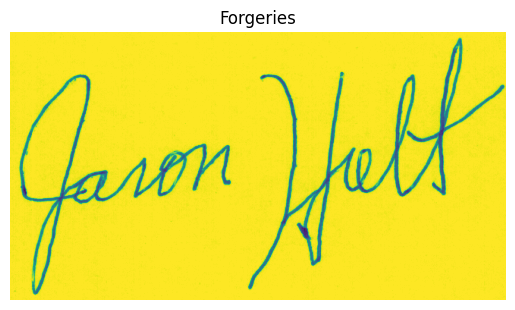

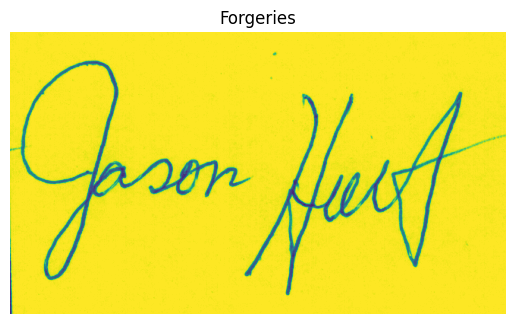

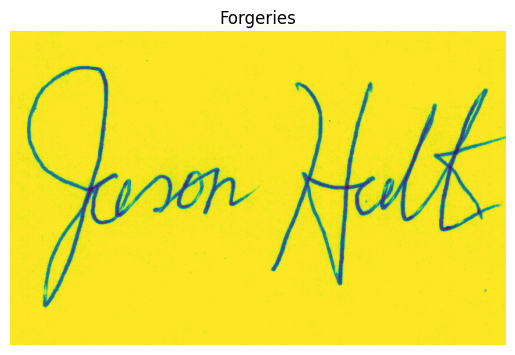

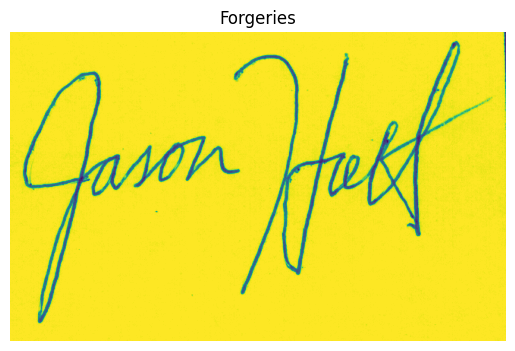

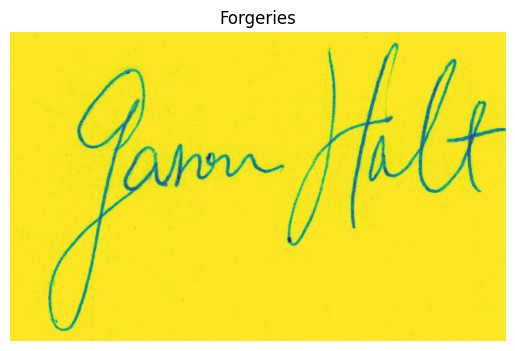

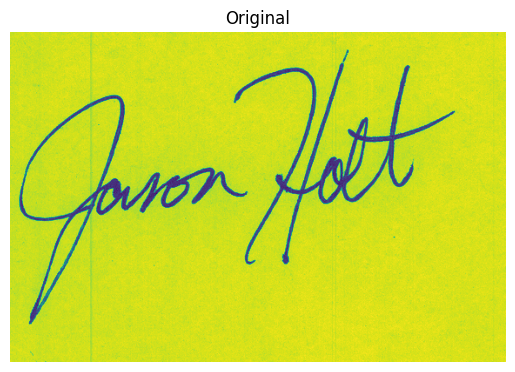

In [7]:
show_image(sample1_forgeries, "Forgeries")
show_image(sample1_original, "Original")

# Image Preprocessing and augmentation

In [8]:
import numpy as np
def extract_blocks(image_list, window_size = (224,224), step_size = 20):
    """
    Extract overlapping blocks from a list of images using a sliding window approach
    and adjust brightness of the blocks.

    Parameters:
    - images: List of images (as numpy arrays).
    - window_size: Tuple (width, height) of the sliding window.
    - step_size: Number of pixels to shift the window each time.

    Returns:
    - List of extracted blocks with brightness adjusted.
    """
    blocks = []
    brightness_factor = 1.075
    # Iterates through each image
    for image in image_list:
      height, width = image.shape[:2]

      # Slide the window across image
      for y in range(0, height-window_size[1]+1, step_size):
        for x in range(0, width-window_size[0]+1, step_size):
          block = image[y:y+window_size[1], x:x + window_size[0]]
          # Adjust brightness: multiply each pixel by the brightness factor
          brightened_block = cv2.multiply(block, np.array([brightness_factor, brightness_factor, brightness_factor]))

          # Clip the values to ensure they are in the valid range [0, 255]
          brightened_block = np.clip(brightened_block, 0, 255).astype(np.uint8)
          blocks.append(brightened_block)
    return blocks
original1_block = extract_blocks(sample1_original)
forgeries1_block = extract_blocks(sample1_forgeries)

In [9]:
len(original1_block), len(forgeries1_block)

(144, 959)

In [10]:
def rotate_blocks(blocks, angle):
    """
    Rotate each sub-image block by a predefined angle until a full 360 degrees rotation is done.

    Parameters:
    - blocks: List of sub-image blocks (as numpy arrays).
    - angle: The angle (in degrees) to rotate each block.

    Returns:
    - List of rotated blocks.
    """
    rotated_blocks = []

    for block in blocks:
        # Get the center of the block for rotation
        center = (block.shape[1] // 2, block.shape[0] // 2)

        # Rotate the block for each angle from 0 to 360 degrees
        for i in range(0, 360, angle):
            # Get the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D(center, i, 1.0)

            # Perform the rotation
            rotated_block = cv2.warpAffine(block, rotation_matrix, (block.shape[1], block.shape[0]))

            # Append the rotated block to the list
            rotated_blocks.append(rotated_block)

    return rotated_blocks
rotated_original1 = rotate_blocks(original1_block, 10)
rotated_forgeries1 = rotate_blocks(forgeries1_block, 30)

In [11]:
len(rotated_original1), len(rotated_forgeries1)

(5184, 11508)

In [12]:
# show_image(rotated_original1[30:35], "Original")
# show_image(rotated_forgeries1[30:35], "Forgeries")

In [13]:
def classify_blocks(blocks, threshold=250, valid_percentage=0.075):
    """
    Classify each sub-image block as valid or invalid based on pixel intensity.

    Parameters:
    - blocks: List of sub-image blocks (as numpy arrays).
    - threshold: Grayscale value threshold for valid pixels.
    - valid_percentage: Percentage threshold for considering a block valid.

    Returns:
    - List of valid blocks.
    """
    valid_blocks = []

    for block in blocks:

        # Count valid pixels that exceed the threshold
        valid_pixel_count = np.sum(block > threshold)
        total_pixel_count = block.size

        # Calculate the percentage of valid pixels
        valid_pixel_ratio = valid_pixel_count / total_pixel_count

        # Check if the ratio exceeds the specified valid percentage
        if valid_pixel_ratio > valid_percentage:
            valid_blocks.append(block)  # Keep valid blocks

    return valid_blocks

valid_original1 = classify_blocks(rotated_original1)
valid_forgeries1 = classify_blocks(rotated_forgeries1)

In [14]:
len(valid_original1), len(valid_forgeries1)

(5184, 11508)

In [15]:
def save_images(images, save_dir, prefix):
    """
    Save images to the specified directory with a given prefix.

    Parameters:
    - images: List of images (as numpy arrays).
    - save_dir: Directory where the images will be saved.
    - prefix: Prefix for the image filenames.
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, img in enumerate(images):
        # Convert to uint8 if necessary and save the image
        img_to_save = (img * 255).astype(np.uint8)  # Assuming img is normalized between 0 and 1
        filename = os.path.join(save_dir, f"{prefix}_{idx}.png")
        cv2.imwrite(filename, img_to_save)


# Save the valid blocks to the 'valid_images' directory
save_images(valid_original1, 'valid_images', 'valid_original')

# Save the forged blocks to the 'forged_images' directory
save_images(valid_forgeries1, 'forged_images', 'valid_forgery')

# Checkpoint 1

# Image/label consistency, train/test split and prepraring the dataloader

In [16]:
import random
images = valid_original1 + valid_forgeries1
labels = [1] * len(valid_original1)+ [0]*len(valid_forgeries1)

combined = list(zip(images, labels))
random.shuffle(combined)
images, labels = zip(*combined)
images = list(images)
labels = list(labels)
print(len(images), len(labels))

16692 16692


In [17]:
type(images), type(labels)

(list, list)

In [18]:
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [19]:
from torchvision import transforms
transform = transforms.ToTensor()
images = [transform(image) for image in images]

In [20]:
type(images[0]), type(labels[0])

(torch.Tensor, int)

In [21]:
# Importing train_test_split from scikit-learn library
from sklearn.model_selection import train_test_split

# Splittin 80% of the data into training set and remaining 20% to testing set
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [22]:
# Sending the data  and labels to the current device to avoid device mismatch error
X_train = [tensor.to(device) for tensor in X_train]
y_train = [torch.tensor(tensor).to(device) for tensor in y_train]
X_test = [tensor.to(device) for tensor in X_test]
y_test = [torch.tensor(tensor).to(device) for tensor in y_test]

In [23]:
X_train_tensor = torch.stack(X_train).to(device)
y_train_tensor = torch.stack(y_train).to(device)
X_test_tensor = torch.stack(X_test).to(device)
y_test_tensor = torch.stack(y_test).to(device)

In [25]:
y_test[0].shape

torch.Size([])

In [26]:
# Checking out the length of train and test sets
print(f'The number of training data is {len(X_train)} and training labels is {len(y_train)}')
print(f'The number of testing data is {len(X_test)} and testing labels is {len(y_test)}')

The number of training data is 13353 and training labels is 13353
The number of testing data is 3339 and testing labels is 3339


In [27]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)


# Setup the batch size hyperparameter
BATCH_SIZE = 4

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,  # dataset to turn into iterable
    batch_size=BATCH_SIZE,  # how many samples per batch?
    shuffle=True  # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False  # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f33f29b3190>, <torch.utils.data.dataloader.DataLoader object at 0x7f33f29b2a10>)
Length of train dataloader: 3339 batches of 4
Length of test dataloader: 835 batches of 4


# Importing the model

In [45]:
import torchvision.models as models
import torch.nn as nn
# Load VGG-19 pretrained model
vgg19 = models.vgg19(pretrained=True)

# Modify the first convolutional layer to accept 1 input channel
vgg19.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Freeze all layers except the last three
for param in list(vgg19.parameters())[:-3]:
    param.requires_grad = False

# Customizing the last layer to match binary classification
num_classes = 2  # number of classes for binary classification
vgg19.classifier[-1] = nn.Linear(vgg19.classifier[-1].in_features, num_classes)

# Move the model to the appropriate device
vgg19 = vgg19.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Performance Metrices, loss function and optimizer

In [49]:
from torch import nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=0.001)

# Define learning rate and momentum
learning_rate = 1e-4
momentum = 0.9

# Initialize SGD optimizer, only including parameters that require gradients
optimizer = optim.SGD(filter(lambda p: p.requires_grad, vgg19.parameters()), lr=learning_rate, momentum=momentum)

In [50]:
# Define a accuracy function
def accuracy(outputs, labels):
    # Get predicted class (no need for sigmoid here)
    predictions = outputs.argmax(dim=1)
    correct = (predictions == labels).sum().item()
    return correct / labels.size(0) * 100  # Convert to percentage

# Training and testing

In [68]:
from tqdm import tqdm

num_epochs = 10
train_losses = []  # Stores average loss per epoch
train_accuracies = []  # Stores average accuracy per epoch

# Training loop
vgg19.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    total_batches = 0

    # Wrap the data loader with tqdm for batch-level tracking
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch + 1}/{num_epochs}]", unit="batch")):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Forward pass (output raw logits, no need for sigmoid)
        outputs = vgg19(X_batch)

        # Calculate loss
        loss = loss_fn(outputs, y_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        acc = accuracy(outputs, y_batch)

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        epoch_accuracy += acc
        total_batches += 1

        # Display results every 500 batches
        if (batch_idx + 1) % 500 == 0:
            avg_loss = epoch_loss / total_batches
            avg_accuracy = epoch_accuracy / total_batches
            print(f'Batch [{batch_idx + 1}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

    # Calculate and print average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_batches
    avg_accuracy = epoch_accuracy / total_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

Epoch [1/10]:  15%|█▌        | 505/3339 [00:18<01:48, 26.09batch/s]

Batch [500], Loss: 0.5269, Accuracy: 75.40%


Epoch [1/10]:  30%|███       | 1003/3339 [00:37<01:28, 26.40batch/s]

Batch [1000], Loss: 0.5364, Accuracy: 74.12%


Epoch [1/10]:  45%|████▌     | 1504/3339 [00:56<01:06, 27.57batch/s]

Batch [1500], Loss: 0.5211, Accuracy: 75.17%


Epoch [1/10]:  60%|█████▉    | 2002/3339 [01:14<00:48, 27.50batch/s]

Batch [2000], Loss: 0.5201, Accuracy: 75.29%


Epoch [1/10]:  75%|███████▍  | 2503/3339 [01:32<00:30, 27.16batch/s]

Batch [2500], Loss: 0.5199, Accuracy: 75.24%


Epoch [1/10]:  90%|████████▉ | 3004/3339 [01:51<00:12, 27.38batch/s]

Batch [3000], Loss: 0.5262, Accuracy: 74.58%


Epoch [1/10]: 100%|██████████| 3339/3339 [02:03<00:00, 27.03batch/s]


Epoch [1/10], Loss: 0.5277, Accuracy: 74.39%


Epoch [2/10]:  15%|█▌        | 504/3339 [00:18<01:43, 27.27batch/s]

Batch [500], Loss: 0.4933, Accuracy: 76.35%


Epoch [2/10]:  30%|███       | 1005/3339 [00:36<01:24, 27.48batch/s]

Batch [1000], Loss: 0.5091, Accuracy: 75.67%


Epoch [2/10]:  45%|████▌     | 1503/3339 [00:55<01:07, 27.19batch/s]

Batch [1500], Loss: 0.5191, Accuracy: 74.97%


Epoch [2/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.51batch/s]

Batch [2000], Loss: 0.5184, Accuracy: 74.99%


Epoch [2/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.33batch/s]

Batch [2500], Loss: 0.5173, Accuracy: 75.29%


Epoch [2/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.38batch/s]

Batch [3000], Loss: 0.5167, Accuracy: 75.34%


Epoch [2/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.32batch/s]


Epoch [2/10], Loss: 0.5181, Accuracy: 75.19%


Epoch [3/10]:  15%|█▌        | 504/3339 [00:18<01:45, 26.94batch/s]

Batch [500], Loss: 0.5327, Accuracy: 74.70%


Epoch [3/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.42batch/s]

Batch [1000], Loss: 0.5214, Accuracy: 75.40%


Epoch [3/10]:  45%|████▌     | 1503/3339 [00:54<01:06, 27.42batch/s]

Batch [1500], Loss: 0.5209, Accuracy: 75.35%


Epoch [3/10]:  60%|██████    | 2004/3339 [01:13<00:49, 27.24batch/s]

Batch [2000], Loss: 0.5174, Accuracy: 75.59%


Epoch [3/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.33batch/s]

Batch [2500], Loss: 0.5177, Accuracy: 75.57%


Epoch [3/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.35batch/s]

Batch [3000], Loss: 0.5168, Accuracy: 75.68%


Epoch [3/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.33batch/s]


Epoch [3/10], Loss: 0.5180, Accuracy: 75.50%


Epoch [4/10]:  15%|█▌        | 504/3339 [00:18<01:43, 27.32batch/s]

Batch [500], Loss: 0.5082, Accuracy: 75.75%


Epoch [4/10]:  30%|███       | 1005/3339 [00:36<01:26, 26.95batch/s]

Batch [1000], Loss: 0.5217, Accuracy: 75.08%


Epoch [4/10]:  45%|████▌     | 1503/3339 [00:55<01:07, 27.31batch/s]

Batch [1500], Loss: 0.5238, Accuracy: 75.00%


Epoch [4/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.52batch/s]

Batch [2000], Loss: 0.5249, Accuracy: 74.89%


Epoch [4/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.49batch/s]

Batch [2500], Loss: 0.5208, Accuracy: 74.98%


Epoch [4/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.08batch/s]

Batch [3000], Loss: 0.5211, Accuracy: 74.88%


Epoch [4/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.36batch/s]


Epoch [4/10], Loss: 0.5209, Accuracy: 74.92%


Epoch [5/10]:  15%|█▌        | 504/3339 [00:18<01:45, 26.93batch/s]

Batch [500], Loss: 0.5398, Accuracy: 73.50%


Epoch [5/10]:  30%|███       | 1005/3339 [00:36<01:24, 27.47batch/s]

Batch [1000], Loss: 0.5288, Accuracy: 74.50%


Epoch [5/10]:  45%|████▌     | 1503/3339 [00:54<01:07, 27.36batch/s]

Batch [1500], Loss: 0.5205, Accuracy: 74.82%


Epoch [5/10]:  60%|██████    | 2004/3339 [01:13<00:49, 26.91batch/s]

Batch [2000], Loss: 0.5204, Accuracy: 74.62%


Epoch [5/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.26batch/s]

Batch [2500], Loss: 0.5212, Accuracy: 74.84%


Epoch [5/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.46batch/s]

Batch [3000], Loss: 0.5173, Accuracy: 75.20%


Epoch [5/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.36batch/s]


Epoch [5/10], Loss: 0.5173, Accuracy: 75.09%


Epoch [6/10]:  15%|█▌        | 504/3339 [00:18<01:43, 27.45batch/s]

Batch [500], Loss: 0.5154, Accuracy: 74.90%


Epoch [6/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.32batch/s]

Batch [1000], Loss: 0.5023, Accuracy: 76.12%


Epoch [6/10]:  45%|████▌     | 1503/3339 [00:54<01:07, 27.19batch/s]

Batch [1500], Loss: 0.5019, Accuracy: 76.33%


Epoch [6/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.30batch/s]

Batch [2000], Loss: 0.5048, Accuracy: 76.21%


Epoch [6/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.35batch/s]

Batch [2500], Loss: 0.5075, Accuracy: 76.03%


Epoch [6/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.19batch/s]

Batch [3000], Loss: 0.5082, Accuracy: 75.97%


Epoch [6/10]: 100%|██████████| 3339/3339 [02:01<00:00, 27.40batch/s]


Epoch [6/10], Loss: 0.5124, Accuracy: 75.64%


Epoch [7/10]:  15%|█▌        | 504/3339 [00:18<01:44, 27.16batch/s]

Batch [500], Loss: 0.5065, Accuracy: 76.30%


Epoch [7/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.39batch/s]

Batch [1000], Loss: 0.5022, Accuracy: 76.78%


Epoch [7/10]:  45%|████▌     | 1503/3339 [00:54<01:07, 27.40batch/s]

Batch [1500], Loss: 0.5122, Accuracy: 75.97%


Epoch [7/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.26batch/s]

Batch [2000], Loss: 0.5143, Accuracy: 76.08%


Epoch [7/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.30batch/s]

Batch [2500], Loss: 0.5128, Accuracy: 76.04%


Epoch [7/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.35batch/s]

Batch [3000], Loss: 0.5183, Accuracy: 75.77%


Epoch [7/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.34batch/s]


Epoch [7/10], Loss: 0.5210, Accuracy: 75.40%


Epoch [8/10]:  15%|█▌        | 504/3339 [00:18<01:42, 27.56batch/s]

Batch [500], Loss: 0.5208, Accuracy: 75.05%


Epoch [8/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.29batch/s]

Batch [1000], Loss: 0.5234, Accuracy: 74.55%


Epoch [8/10]:  45%|████▌     | 1503/3339 [00:54<01:07, 27.25batch/s]

Batch [1500], Loss: 0.5255, Accuracy: 74.28%


Epoch [8/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.46batch/s]

Batch [2000], Loss: 0.5208, Accuracy: 74.65%


Epoch [8/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.46batch/s]

Batch [2500], Loss: 0.5167, Accuracy: 75.00%


Epoch [8/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 26.80batch/s]

Batch [3000], Loss: 0.5142, Accuracy: 75.36%


Epoch [8/10]: 100%|██████████| 3339/3339 [02:01<00:00, 27.38batch/s]


Epoch [8/10], Loss: 0.5132, Accuracy: 75.36%


Epoch [9/10]:  15%|█▌        | 504/3339 [00:18<01:45, 26.98batch/s]

Batch [500], Loss: 0.4975, Accuracy: 76.25%


Epoch [9/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.40batch/s]

Batch [1000], Loss: 0.5283, Accuracy: 74.58%


Epoch [9/10]:  45%|████▌     | 1503/3339 [00:55<01:07, 27.31batch/s]

Batch [1500], Loss: 0.5279, Accuracy: 74.68%


Epoch [9/10]:  60%|██████    | 2004/3339 [01:13<00:49, 27.20batch/s]

Batch [2000], Loss: 0.5211, Accuracy: 75.09%


Epoch [9/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.38batch/s]

Batch [2500], Loss: 0.5198, Accuracy: 75.18%


Epoch [9/10]:  90%|████████▉ | 3003/3339 [01:50<00:12, 27.47batch/s]

Batch [3000], Loss: 0.5157, Accuracy: 75.35%


Epoch [9/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.30batch/s]


Epoch [9/10], Loss: 0.5154, Accuracy: 75.35%


Epoch [10/10]:  15%|█▌        | 504/3339 [00:18<01:43, 27.51batch/s]

Batch [500], Loss: 0.5305, Accuracy: 74.20%


Epoch [10/10]:  30%|███       | 1005/3339 [00:36<01:25, 27.20batch/s]

Batch [1000], Loss: 0.5188, Accuracy: 74.70%


Epoch [10/10]:  45%|████▌     | 1503/3339 [00:55<01:06, 27.54batch/s]

Batch [1500], Loss: 0.5157, Accuracy: 75.07%


Epoch [10/10]:  60%|██████    | 2004/3339 [01:13<00:48, 27.48batch/s]

Batch [2000], Loss: 0.5132, Accuracy: 75.22%


Epoch [10/10]:  75%|███████▌  | 2505/3339 [01:31<00:30, 27.39batch/s]

Batch [2500], Loss: 0.5130, Accuracy: 75.11%


Epoch [10/10]:  90%|████████▉ | 3003/3339 [01:49<00:12, 27.01batch/s]

Batch [3000], Loss: 0.5107, Accuracy: 75.27%


Epoch [10/10]: 100%|██████████| 3339/3339 [02:02<00:00, 27.32batch/s]

Epoch [10/10], Loss: 0.5103, Accuracy: 75.37%


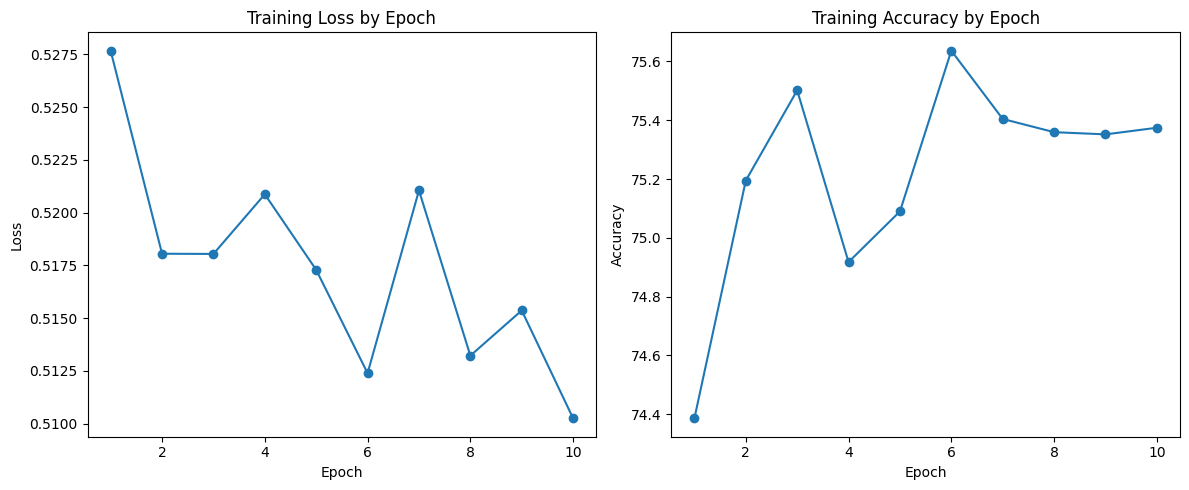

In [69]:
import matplotlib.pyplot as plt

# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss as a line graph
ax1.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss by Epoch')

# Plot training accuracy as a line graph
ax2.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy by Epoch')

plt.tight_layout()
plt.show()


Evaluating: 100%|██████████| 835/835 [00:31<00:00, 26.92batch/s]


Test Loss: 0.4677, Test Accuracy: 80.51%


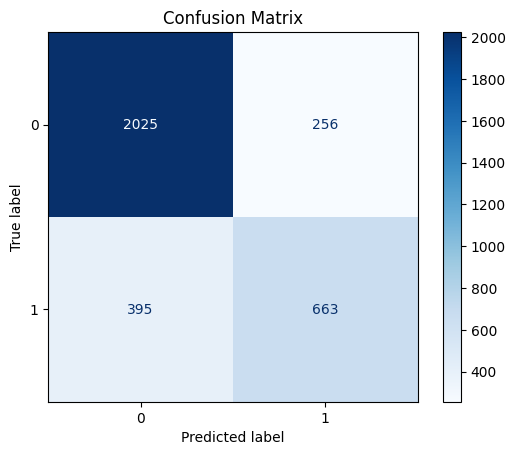

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluation loop with confusion matrix
vgg19.eval()  # Set model to evaluation mode
test_loss = 0.0
test_accuracy = 0.0
total_batches = 0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient tracking for evaluation
    for X_batch, y_batch in tqdm(test_dataloader, desc="Evaluating", unit="batch"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = vgg19(X_batch)

        # Calculate loss
        loss = loss_fn(outputs, y_batch)

        # Calculate accuracy
        acc = accuracy(outputs, y_batch)

        # Accumulate loss and accuracy
        test_loss += loss.item()
        test_accuracy += acc
        total_batches += 1

        # Store predictions and labels for confusion matrix
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Calculate average loss and accuracy
avg_test_loss = test_loss / total_batches
avg_test_accuracy = test_accuracy / total_batches

# Print test results
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
